Plotting the impact on P_NL(k,z=0) of the parameters of CWDM.
Meant to work with the public CLASS and emulator of Parimbelli et al.

In [1]:
from classy import Class
from matplotlib import pyplot as plt
import numpy as np

In [3]:
# We need the emulator to compute [P_LCWDM^NL / P_LCDM^NL]

# Our fundamental WDM parameters are:
# - f_WDM = omega_WDM/omega_DM 
# - x = (m_WDM/T_WDM)*(4/11)^(1/3)*T_gamma in eV

# When calling the emulator we need to convert these into m_wdm, omega_wdm
# Given the way in wich the emulator has been built, the conversion reads

# f_wdm = f_WDM
# omega_wdm = f_WDM * omega_DM
# m_wdm = (omega_wdm * 93.14 eV)^(1/4) * x^(3/4) 

def emulator(f_wdm,m_wdm):
    return 1

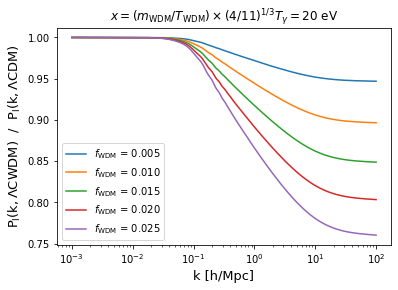

In [5]:
# We need CLASS to compute P_lcdm^NL (for multiplying with emulator) 
# and P_LCWDM^L, P_LCDM^L (just for plotting purpose)

# Our fundamental WDM parameters are:
# - f_WDM = omega_WDM/omega_DM 
# - x = (m_WDM/T_WDM)*(4/11)^(1/3)*T_gamma in eV

# When calling CLASS we need to convert these into (m_ncdm, T_ncdm), on top of passing omega_ncdm = omega_wdm
# For the conversion, it should be strictly equivalent to assume:
# 1. Dodelson-Widrow WDM
# 2. Thermal WDM
# 3. The model assumed when building the emulator, 
#    which is almost thermal WDM up to the mass rescaling
#    m_WDM^emulator = m_WDM^thermal * (94.1/93/14)^(1/4) = 1.0026 m_WDM^thermal

# The notebook in parameter_effects proves this exact equivalence
# Thus, here, we choose to stick to 3. for homogeneity with emulator

kmax = 100
omega_dm = 0.1201075

ref = Class()
ref.set({
    'output':'mPk',
    'P_k_max_h/Mpc':kmax,
    'non linear':'halofit',
    'omega_cdm':omega_dm
          })
ref.compute()

kk = np.logspace(np.log10(0.001),np.log10(kmax),1000)
h = ref.h()
pk_ref_lin = np.vectorize(ref.pk_lin)(kk*h,0)
pk_ref_nl = np.vectorize(ref.pk)(kk*h,0)

# The following plots will have a fixed omega_DM and x and varying f_wdm

x = 20 # in eV
f_list = np.linspace(0.005,0.025,5)


model = Class()

for f_wdm in f_list :
    omega_wdm = omega_dm*f_wdm
    m_wdm = (omega_wdm*93.14)**0.25 * x**0.75
    Twdm_over_Tgamma = (omega_wdm*93.14)**0.25 * x**-0.25 * (4./11.)**(1./3.)
    
    # call class
    model.set({
        'output':'mPk',
        'non linear':'halofit',
        'N_ncdm':1,
        'm_ncdm':m_wdm,
        'T_ncdm' : Twdm_over_Tgamma,
        #'YHe' : 0.24,
        'P_k_max_h/Mpc':kmax,
        'omega_cdm' :  omega_dm*(1.-f_wdm),
        'omega_ncdm' : omega_wdm
            })
    model.compute()
    h=model.h()
    pk_cwdm_lin = np.vectorize(model.pk_lin)(kk*h,0)
    
    # call emulator
    emulator(f_wdm,m_wdm)
    
    # plot CWDM_L /CDM_L 
    plt.plot(kk,pk_cwdm_lin /pk_ref_lin, label = r'$f_\mathrm{WDM}$'+r' = {a:.3f}'.format(a=f_wdm))    
    
    # plot CWDM_NL / CDM_NL
    # just plot "emulator"
    
    # plot CWDM_NL / CDM_L
    # emulator * pk_ref_nl / pk_ref_lin
    
plt.xscale('log')
plt.yscale('linear')
    
plt.ylabel(r'$\mathrm{P_l(k,\Lambda CWDM) \ \ / \ \ P_l(k,\Lambda CDM)}$', fontsize=13)
plt.xlabel(r'k [h/Mpc]', fontsize=13)
#plt.title(r'$x = \frac{m_\mathrm{WDM}}{T_\mathrm{WDM}} \left(\frac{4}{11}\right)^{1/3} T_\gamma$= {a} eV'.format(a=m))
plt.title(r'$x = (m_\mathrm{WDM}/T_\mathrm{WDM}) \times (4/11)^{1/3} T_\gamma =$'+r'{a} eV'.format(a=x))
plt.legend()
plt.savefig('ratio_of_pklin.png')

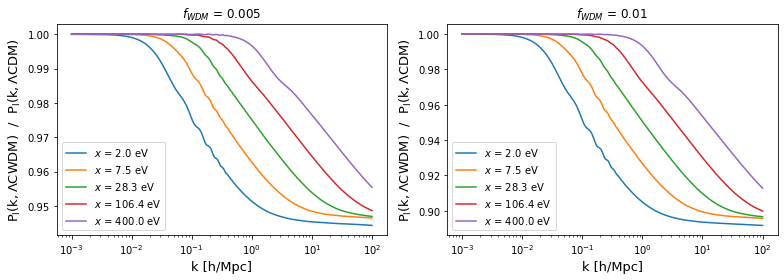

In [7]:
# same as previous cell with a fixed x and varying f_WDM

kmax = 100
omega_dm = 0.1201075

ref = Class()
ref.set({
    'output':'mPk',
    'P_k_max_h/Mpc':kmax,
    'non linear':'halofit',
    'omega_cdm':omega_dm
          })
ref.compute()

kk = np.logspace(np.log10(0.001),np.log10(kmax),1000)
h = ref.h()
pk_ref_lin = np.vectorize(ref.pk_lin)(kk*h,0)
pk_ref_nl = np.vectorize(ref.pk)(kk*h,0)

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(11,4))

# The following plots will have a fixed omega_DM, two fixed values of f_wdm and varying x

f_list = [0.005,0.01]
x_list = np.geomspace(2,400,5)


model = Class()

for i in range(2) :
    for x in x_list :
        f_wdm = f_list[i]
        omega_wdm = omega_dm*f_wdm
        m_wdm = (omega_wdm*93.14)**0.25 * x**0.75
        Twdm_over_Tgamma = (omega_wdm*93.14)**0.25 * x**-0.25 * (4./11.)**(1./3.)
        model.set({
            'output':'mPk',
            'non linear':'halofit',
            'N_ncdm':1,
            'm_ncdm':m_wdm,
            'T_ncdm':Twdm_over_Tgamma,
            'YHe' : 0.24,
            'P_k_max_h/Mpc':kmax,
            'omega_cdm' :  omega_dm*(1.-f_wdm),
            'omega_ncdm' : omega_wdm
                  })
        model.compute()
        h=model.h()
        pk_cwdm_lin = np.vectorize(model.pk_lin)(kk*h,0)
        
        # call emulator
        emulator(f_wdm,m_wdm)
    
        # plot CWDM_L /CDM_L 
        ax[i].plot(kk,pk_cwdm_lin /pk_ref_lin, label = r'$x$ = {a:1.1f} eV'.format(a=x))   
    
        # plot CWDM_NL / CDM_NL
        # just plot "emulator"
    
        # plot CWDM_NL / CDM_L
        # emulator * pk_ref_nl /pk_ref_lin
        
    ax[i].set_xscale('log')
    ax[i].set_yscale('linear')
    ax[i].set_title(r'$f_{WDM}$ ' + '= {a}'.format(a=f_wdm))

    ax[i].set_ylabel(r'$\mathrm{P_l(k,\Lambda CWDM) \ \ / \ \ P_l(k,\Lambda CDM)}$', fontsize=13)
    ax[i].set_xlabel(r'k [h/Mpc]', fontsize=13)
    ax[i].legend()

plt.tight_layout()
plt.savefig('ratio_of_pklin_mnu.png')